In [1]:
from python_graphql_client import GraphqlClient
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools
import random
import re
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("ticks")

In [2]:
mapdata = dict()

with open('data/zonemap.json', 'r') as f:
    mapdata = json.load(f)

zones = mapdata['data']['zonesStats']
zones_map = {zone['zone']: zone['name'] for zone in zones}
channels = mapdata['data']['zonesGraphs']

In [3]:
marketdata_raw = dict()
with open('data/marketcap.json', 'r') as f:
    marketdata_raw = json.load(f)

marketdata = dict()
for asset in marketdata_raw['data']['assets']:
    marketdata[asset['blockchain']['name']] = asset['marketCap']

In [4]:
G = nx.Graph()
for zone in zones:
    if zone['name'] in marketdata and marketdata[zone['name']] != None:
        market_cap = int(marketdata[zone['name']])
        G.add_node(zone['zone'], weight=market_cap)

for chan in channels:
    if chan["ibcVolume"] == 0:
        continue
    if chan["source"] not in G.nodes:
        continue
    if chan['target'] not in G.nodes:
        continue
    G.add_edge(chan["source"], chan["target"], weight=chan["ibcVolume"])

G

In [5]:
total_cap = 0

for node in G.nodes():
    total_cap += G.nodes[node]['weight']
print(total_cap)

9309518673


In [6]:
def get_frequency(src, dst):
    f = open('data/peers/%s.json' % src, 'r')
    src_ibc_data = json.load(f)
    src_peers = src_ibc_data['data']['zones']
    for peer in src_peers:
        if dst == peer['data']['zoneChannels'][0]['zoneCounterparty']['zone']:
            ibcTransfers = peer['data']['aggregate']['sum']['ibcTransfers']
            frequency = ibcTransfers / 24.0
            return frequency # per hr

    return 0

def get_all_frequencies():
    zone_pairs = list(itertools.combinations(zones, 2))
    for pair in zone_pairs:
        zone0, zone1 = pair[0]['zone'], pair[1]['zone']
        frequency = get_frequency(zone0, zone1)
        print(zone0, zone1, frequency)

get_all_frequencies()

crescent-1 cronosmainnet_25-1 0
crescent-1 crypto-org-chain-mainnet-1 0
crescent-1 darchub 0
crescent-1 desmos-mainnet 0
crescent-1 dig-1 0
crescent-1 emoney-3 0
crescent-1 evmos_9001-2 0.0
crescent-1 fetchhub-4 0
crescent-1 agoric-3 2.125
crescent-1 akashnet-2 0
crescent-1 axelar-dojo-1 2.8333333333333335
crescent-1 bitcanna-1 0
crescent-1 bitsong-2b 0
crescent-1 bostrom 0
crescent-1 alteredcarbon 0
crescent-1 canto_7700-1 0
crescent-1 kichain-2 0
crescent-1 laozi-mainnet 0
crescent-1 likecoin-mainnet-2 0
crescent-1 lum-network-1 0
crescent-1 mainnet-3 0
crescent-1 mantle-1 0.0
crescent-1 vidulum-1 0
crescent-1 cheqd-mainnet-1 0
crescent-1 chihuahua-1 0
crescent-1 columbus-5 0.6666666666666666
crescent-1 comdex-1 1.8333333333333333
crescent-1 core-1 0
crescent-1 cosmoshub-4 9.916666666666666
crescent-1 exchain-66 0
crescent-1 gravity-bridge-3 1.9166666666666667
crescent-1 impacthub-3 0
crescent-1 injective-1 0.7916666666666666
crescent-1 iov-mainnet-ibc 0
crescent-1 irishub-1 0
cresce

In [23]:
def aggregate_node_weights(G, path):
    """
    Calculate sum of the weights in a path.
    """
    weights = [G.nodes[node]['weight'] for node in path]
    economic_security = sum(weights) / 3
    censorship_resistance = min(weights) / 3
    return economic_security, censorship_resistance

def find_heaviest_path(G, source, target, cutoff):
    """
    Find the heaviest path between source and target nodes.
    """
    max_path = []
    max_economic_security = 0
    cor_censorship_resistance = 0
    for path in nx.all_simple_paths(G, source, target, cutoff=cutoff):
        economic_security, censorship_resistance = aggregate_node_weights(G, path)
        if economic_security > max_economic_security:
            max_path = path
            max_economic_security = economic_security
            cor_censorship_resistance = censorship_resistance
    return max_path, max_economic_security, cor_censorship_resistance

# find_heaviest_path_all finds the heaviest path with length cutoff+1 for all nodes in the graph
# where heaviest means the total weights of nodes in the path is largest
def find_heaviest_path_all(G, cutoff=0):
    heaviest_paths = []
    max_economic_security_list = []
    cor_censorship_resistance_list = []
    nodes = list(G.nodes)
    for src in nodes:
        max_path = [src]
        max_economic_security = G.nodes[src]['weight'] / 3
        cor_censorship_resistance = G.nodes[src]['weight'] / 3
        for dst in nodes:
            max_path1, max_economic_security1, cor_censorship_resistance1 = find_heaviest_path(G, src, dst, cutoff)
            if max_economic_security1 >= max_economic_security:
                max_path = max_path1
                max_economic_security = max_economic_security1
                cor_censorship_resistance = cor_censorship_resistance1
        heaviest_paths.append(max_path)
        max_economic_security_list.append(max_economic_security)
        cor_censorship_resistance_list.append(cor_censorship_resistance)
    return heaviest_paths, max_economic_security_list, cor_censorship_resistance_list

paths, max_economic_security_list, cor_censorship_resistance_list = find_heaviest_path_all(G, cutoff=1)
max_economic_security_list, cor_censorship_resistance_list

([1467955327.3333333,
  1532305380.0,
  753455010.6666666,
  708069.6666666666,
  9649886.666666666,
  111804.0,
  40866963.666666664,
  1536578845.3333333,
  99970712.0,
  198999423.33333334,
  56207543.333333336,
  1468429353.0,
  42170176.0,
  40025609.0,
  1474468930.0,
  1509988874.6666667,
  1486762036.3333333,
  89206180.0,
  8897422.0,
  9811094.0,
  8322003.0,
  41438312.0,
  8218186.333333333,
  19058479.0,
  65271847.666666664,
  1471735616.3333333,
  1499945381.0,
  1536578845.3333333,
  24.666666666666668,
  1474208147.3333333,
  819848.0,
  1497252159.6666667,
  8289860.333333333,
  1478485912.0,
  17980124.666666668,
  1506947993.0,
  1491836638.0,
  1475371333.6666667,
  55120967.0,
  17307437.0,
  1529504676.3333333,
  64058523.0,
  29533162.0,
  1467670518.0,
  45883857.333333336,
  58887747.333333336,
  1469286679.0,
  6119402.333333333,
  1495893236.3333333],
 [680985.6666666666,
  65031038.333333336,
  65031038.333333336,
  708069.6666666666,
  1552894.6666666667,


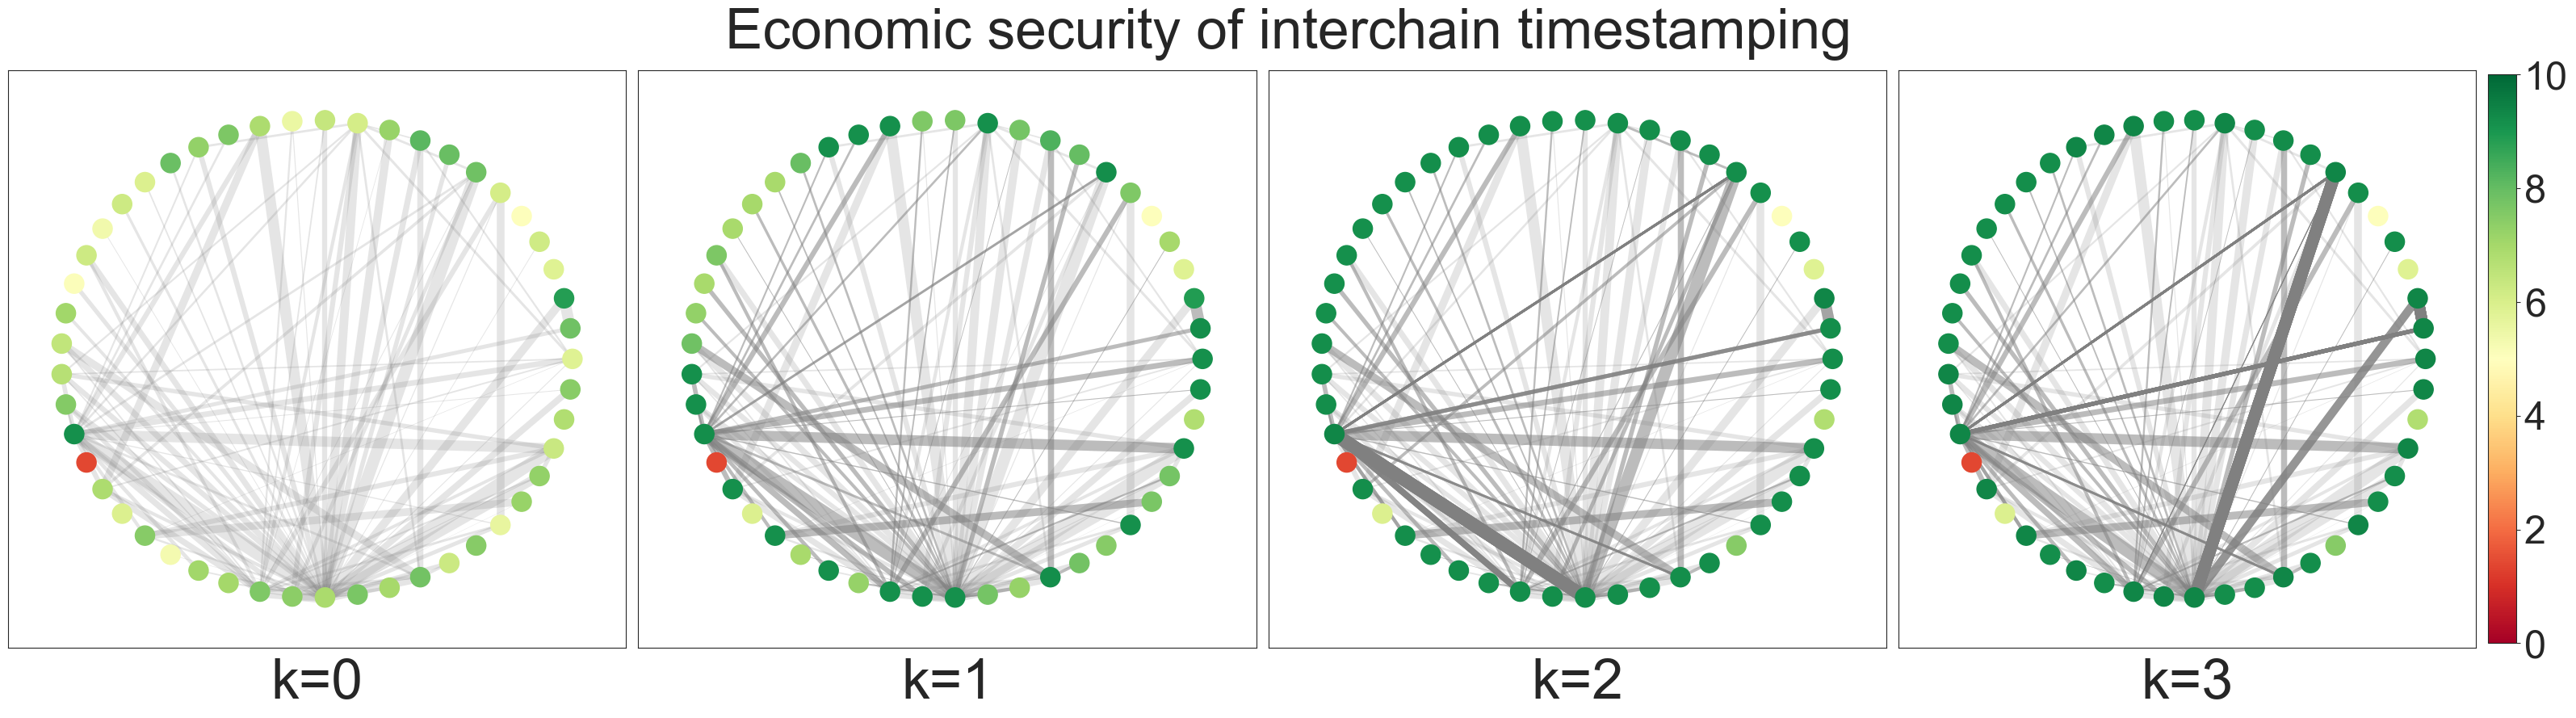

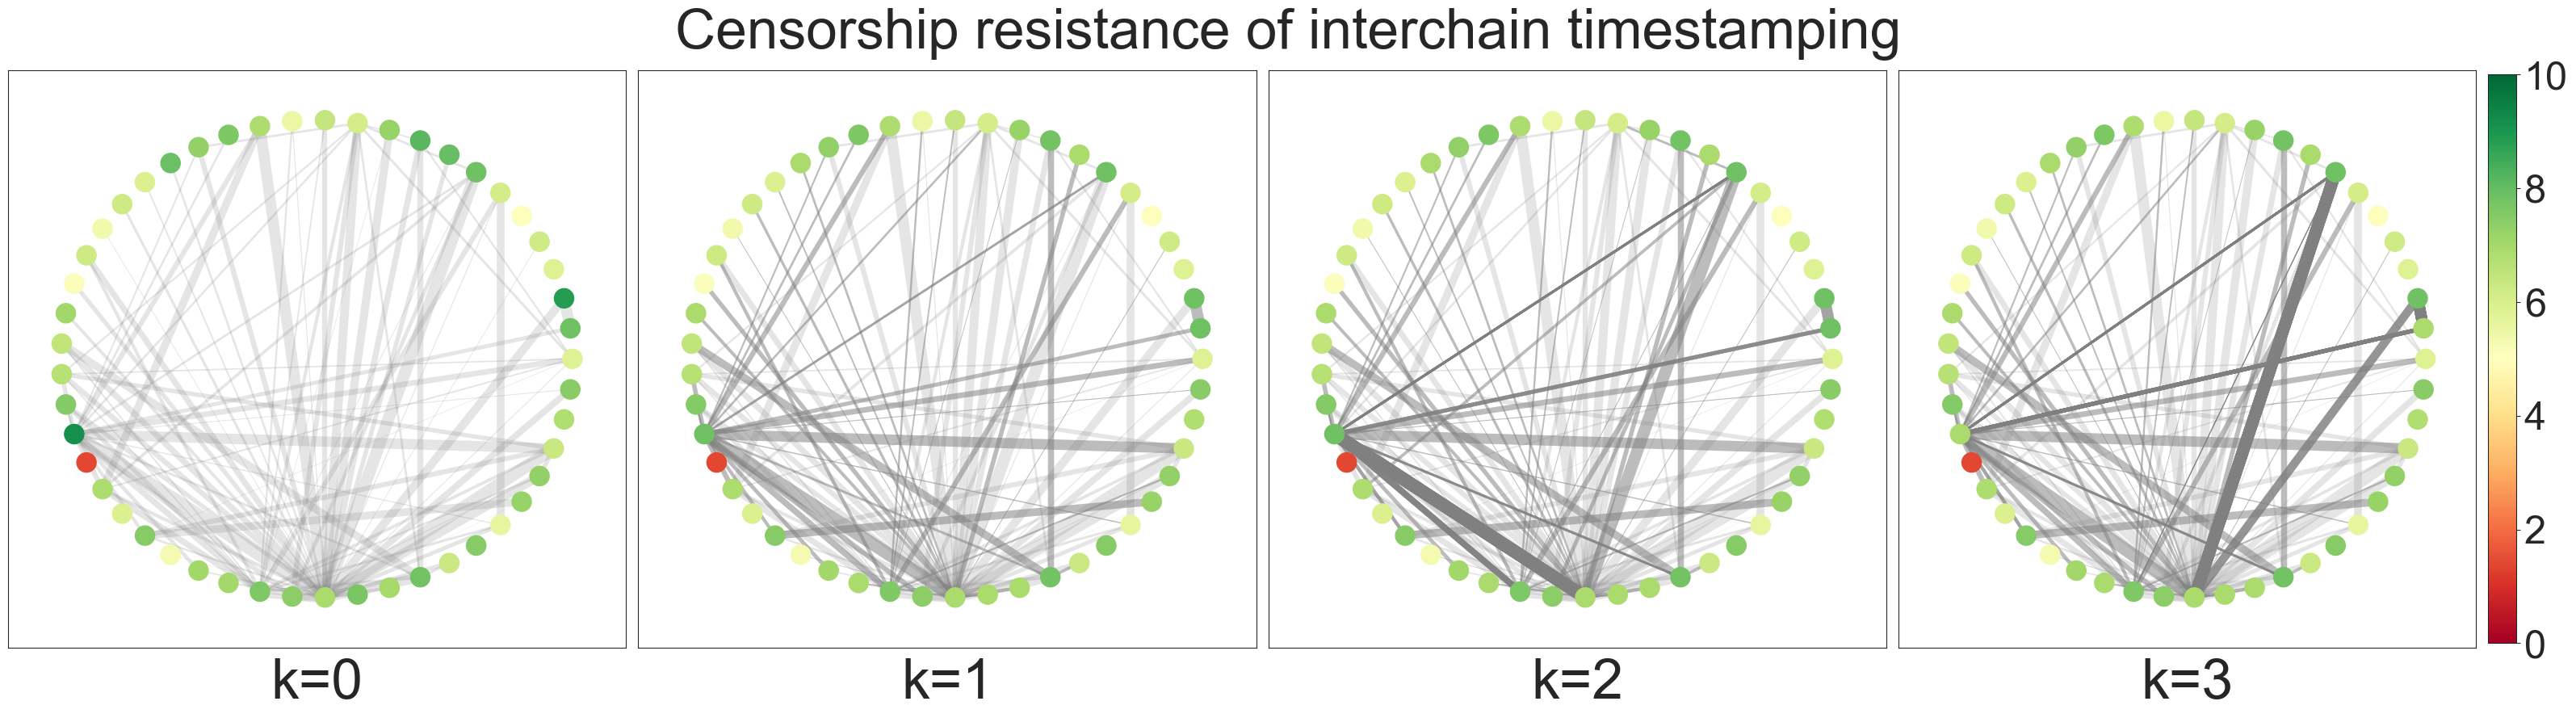

In [40]:
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

def draw_map_of_zones_economic_security(G, cutoffs=[0,1,2,3]):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(32, 9))
    pos = nx.circular_layout(G)
    cmap = plt.cm.get_cmap('RdYlGn')
    # cmap = plt.cm.jet

    for cutoff in cutoffs:
        plt.subplot(141+cutoff)

        heaviest_paths, heaviest_weights, _ = find_heaviest_path_all(G, cutoff)
        # zone name of each vertex
        node_labels = {node: zones_map[node] for node in G.nodes}
        # weight of each vertex, i.e., normalised 1/3 market cap in the heaviest path
        node_weights = [math.log10(weight) for weight in heaviest_weights] 
        # node_weights = heaviest_weights
        # weight of each edge, i.e., normalised frequency of the channel
        edge_weights = [math.log10(get_frequency(edge[0], edge[1]))*5 for edge in G.edges(data='weight')] 

        # pos = nx.nx_agraph.pygraphviz_layout(G)
        # pos = nx.spring_layout(G, k=20, iterations=20)
        nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2, edge_color='grey')
        nc = nx.draw_networkx_nodes(G, pos, node_labels, node_color=node_weights, cmap=cmap, vmin=0, vmax=10)

        # labels = nx.draw_networkx_labels(G,pos,node_labels,font_size=16,font_color='r')

        # use transparency to indicate edges that provide security for zones
        if cutoff > 0:
            for path in heaviest_paths:
                for x, y in zip(path, path[1:]):
                    edge_weight = math.log10(get_frequency(x, y))*5
                    nx.draw_networkx_edges(G, pos, edgelist=[[x,y]], alpha = 0.4, width=[edge_weight], edge_color='grey')
        
        plt.title('k=%d' % (cutoff), fontsize=50, y=-0.1)

    # cbar = plt.colorbar(nc, format=ticker.FuncFormatter(fmt),fraction=0.046, pad=0.02)
    cbar = fig.colorbar(nc,fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=35)
    fig.suptitle("Economic security of interchain timestamping", fontsize=50)

    plt.tight_layout()
    plt.savefig('../../Babylon/mesh-security-paper/figures/zones-summary-economic-security.pdf')
    plt.show()

def draw_map_of_zones_censorship_resistance(G, cutoffs=[0,1,2,3]):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(32, 9))
    pos = nx.circular_layout(G)
    cmap = plt.cm.get_cmap('RdYlGn')
    # cmap = plt.cm.jet

    for cutoff in cutoffs:
        plt.subplot(141+cutoff)

        heaviest_paths, _, heaviest_weights = find_heaviest_path_all(G, cutoff)
        # zone name of each vertex
        node_labels = {node: zones_map[node] for node in G.nodes}
        # weight of each vertex, i.e., normalised 1/3 market cap in the heaviest path
        node_weights = [math.log10(weight) for weight in heaviest_weights] 
        # node_weights = heaviest_weights
        # weight of each edge, i.e., normalised frequency of the channel
        edge_weights = [math.log10(get_frequency(edge[0], edge[1]))*5 for edge in G.edges(data='weight')] 

        # pos = nx.nx_agraph.pygraphviz_layout(G)
        # pos = nx.spring_layout(G, k=20, iterations=20)
        nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2, edge_color='grey')
        nc = nx.draw_networkx_nodes(G, pos, node_labels, node_color=node_weights, cmap=cmap, vmin=0, vmax=10)

        # labels = nx.draw_networkx_labels(G,pos,node_labels,font_size=16,font_color='r')

        # use transparency to indicate edges that provide security for zones
        if cutoff > 0:
            for path in heaviest_paths:
                for x, y in zip(path, path[1:]):
                    edge_weight = math.log10(get_frequency(x, y))*5
                    nx.draw_networkx_edges(G, pos, edgelist=[[x,y]], alpha = 0.4, width=[edge_weight], edge_color='grey')
        
        plt.title('k=%d' % (cutoff), fontsize=50, y=-0.1)

    # cbar = plt.colorbar(nc, format=ticker.FuncFormatter(fmt),fraction=0.046, pad=0.02)
    cbar = fig.colorbar(nc,fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=35)

    fig.suptitle("Censorship resistance of interchain timestamping", fontsize=50)
    plt.tight_layout()
    plt.savefig('../../Babylon/mesh-security-paper/figures/zones-summary-censorship-resistance.pdf')
    plt.show()

draw_map_of_zones_economic_security(G)
draw_map_of_zones_censorship_resistance(G)

In [9]:
gas_usage = []
pattern = re.compile(" gas_used=\d* ")
with open('data/relayer.log', 'r') as f:
    for line in f.readlines():
        if "msg_types=/ibc.core.client.v1.MsgUpdateClient" in line:
            m = pattern.search(line)
            if m:
                gas_usage_str = int(m.group(0).strip().split('=')[1])
                gas_usage.append(gas_usage_str)

gas_usage_np = np.array(gas_usage)
print(gas_usage_np.mean(), gas_usage_np.std(), len(gas_usage_np))

217052.7856 53472.09122465693 625


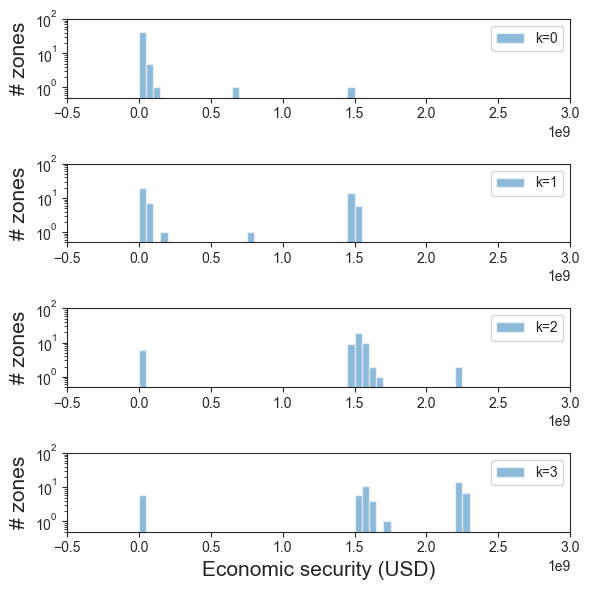

In [46]:
cutoffs = [0,1,2,3]
bins = np.arange(0, 3*10**9, 5*10**7)
fig = plt.figure(figsize=(6, 6))

for cutoff in cutoffs:
    plt.subplot(411+cutoff)
    _, heaviest_weights, _ = find_heaviest_path_all(G, cutoff)
    plt.hist(heaviest_weights, bins=bins, label='k=%d' % cutoff, alpha=0.5)
    if cutoff == 3:
        plt.xlabel('Economic security (USD)', fontsize=15)
    plt.ylabel('# zones', fontsize=15)
    plt.xlim([-5*10**8, 3*10**9])
    plt.ylim([0.5, 100])
    plt.yscale('log')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../../Babylon/mesh-security-paper/figures/security-hist.pdf')
plt.show()

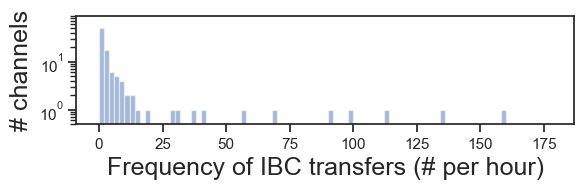

In [143]:

bins = np.arange(0, 180, 2)

fig = plt.figure(figsize=(6, 2))
edge_weights = [get_frequency(edge[0], edge[1]) for edge in G.edges(data='weight')]
plt.hist(edge_weights, bins=bins, alpha=0.5)
plt.yscale('log')
plt.ylim([0.5, 90])
plt.xlabel('Frequency of IBC transfers (# per hour)', fontsize=18)
plt.ylabel('# channels', fontsize=18)
plt.tight_layout()
plt.savefig('../../Babylon/mesh-security-paper/figures/ibc-transfer-frequency-hist.pdf')
plt.show()

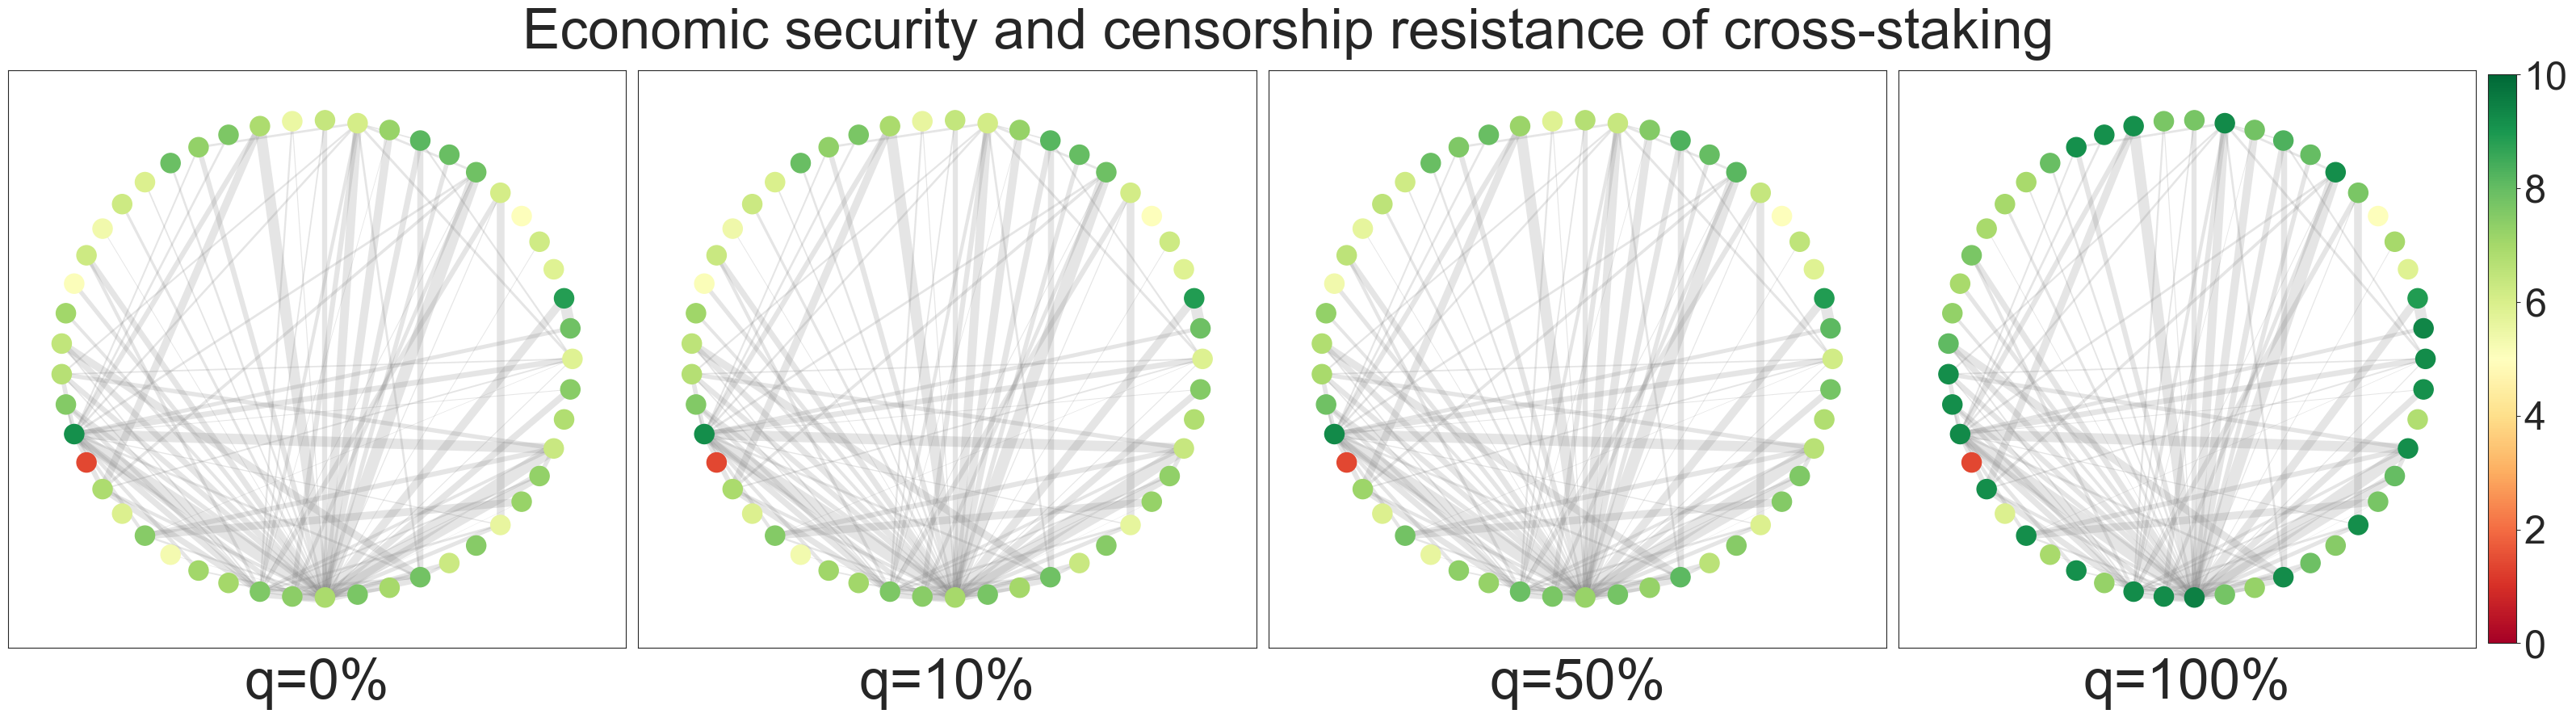

In [41]:
def find_optimal_security(G, node, beta):
    # total weight of all peers
    peers = G.neighbors(node)
    max_weight_from_peers = 0
    for peer in peers:
        max_weight_from_peers += G.nodes[peer]['weight']
    if beta == 1:
        return (max_weight_from_peers + G.nodes[node]['weight']) / 3
    max_borrowable_weight = beta * G.nodes[node]['weight'] / (1-beta)
    if max_weight_from_peers < max_borrowable_weight:
        return (max_weight_from_peers + G.nodes[node]['weight']) / 3
    else:
        return (max_borrowable_weight + G.nodes[node]['weight']) / 3

def find_optimal_security_all(G, beta):
    return [find_optimal_security(G, node, beta) for node in G.nodes]

def draw_map_of_zones_summary_cross_chain_validation(G, betas=[0, 0.1, 0.5, 1]):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(32, 9))
    pos = nx.circular_layout(G)
    cmap = plt.cm.get_cmap('RdYlGn')
    # cmap = plt.cm.jet

    for idx, beta in enumerate(betas):
        plt.subplot(141+idx)

        # zone name of each vertex
        node_labels = {node: zones_map[node] for node in G.nodes}

        # weight of each vertex, i.e., normalised market cap in the heaviest path
        heaviest_weights = find_optimal_security_all(G, beta)
        node_weights = [math.log10(weight) for weight in heaviest_weights] 
        # node_weights = heaviest_weights
        # weight of each edge, i.e., normalised frequency of the channel
        edge_weights = [math.log10(get_frequency(edge[0], edge[1]))*5 for edge in G.edges(data='weight')] 

        nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2, edge_color='grey')
        nc = nx.draw_networkx_nodes(G, pos, node_labels, node_color=node_weights, cmap=cmap, vmin=0, vmax=10)

        plt.title("q={0:.0%}".format(beta), fontsize=50, y=-0.1)

    # cbar = plt.colorbar(nc, format=ticker.FuncFormatter(fmt),fraction=0.046, pad=0.02)
    cbar = fig.colorbar(nc,fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=35)

    fig.suptitle("Economic security and censorship resistance of cross-staking", fontsize=50)
    plt.tight_layout()
    plt.savefig('../../Babylon/mesh-security-paper/figures/zones-ccv-summary.pdf')
    plt.show()

# find_optimal_security_all(G, 0.2)
draw_map_of_zones_summary_cross_chain_validation(G)